<a href="https://colab.research.google.com/github/sanchitgulati/ML-notebooks/blob/main/ppo_openAI_custom_game_reinforcement_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train an AI to play a game of your own with Stable-Baselines3

## Define the game environment

Here we define the game we want the AI to play using the OpenAI Gym class gym.env format. In the example here we set up a Snake game with two walls in the middle.
We further need to define 3 things here:
1. What information does the player have about the state of the game (i.e., observation space)?
2. What possible actions the player can take (i.e., action space)?
3. What is the reward scheme?

In [1]:
%%capture
!pip install stable-baselines3

In [2]:
import matplotlib.animation as animation
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class Snake_game(gym.Env):
    """
    Custom Environment for Stable Baseline 3 for the classic Snake 
    """
    metadata = {'render.modes': ['console','rgb_array']}


    #Direction constants
    n_actions = 3 #3 possible steps each turn
    LEFT = 0
    STRAIGHT = 1
    RIGHT = 2
    #Grid label constants
    EMPTY = 0
    SNAKE = 1
    SNAKE_HEAD = 2
    WALL = 3
    FOOD = 4


    #Rewards
    REWARD_WALL_HIT = -100 #should be lower than -REWARD_PER_STEP_TOWARDS_FOOD to avoid hitting wall intentionally
    REWARD_PER_STEP_TOWARDS_FOOD = 0.1 #give reward for moving towards food and penalty for moving away
    REWARD_PER_FOOD = 50
    REWARD_PER_TURN = -0.1
    REWARD_PER_STRAIGHT = 0.2

    # Constants
    MAX_STEPS_AFTER_FOOD = 500 #stop if we go too long without food to avoid infinite loops


    def __init__(self, grid_size=12):
        super(Snake_game, self).__init__()
        
        # Size of the 2D grid (including walls)
        self.grid_size = grid_size
  
        #Init the grid
        self.reset()

        # The action space, total of 3 inputs 
        self.action_space = spaces.Discrete(self.n_actions)

        # The observation space
        # The observation space, "position" is the coordinates of the head; "direction" is which way the sanke is heading, "grid" contains the full grid info
        self.observation_space = gym.spaces.Dict(
            spaces={
                "wall" :gym.spaces.MultiBinary(grid_size*grid_size),
                "snake_array" :gym.spaces.MultiBinary(grid_size*grid_size),
                "food_array" :gym.spaces.MultiBinary(grid_size*grid_size),
                "position": gym.spaces.Box(low=0, high=(self.grid_size-1), shape=(2,), dtype=np.int32),
                "direction": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=np.int32),
            })
        # self.observation_space = gym.spaces.Box(0,1,(self.grid_size, self.grid_size,4), dtype=bool)
        
    def _get_obs(self):
      direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])
      game_state = self.game_state();
      return { "wall" : game_state[0].flatten(),
                "snake_array" :game_state[1].flatten(),
                "food_array" :game_state[3].flatten(),
                "position": np.array(self.snake_coordinates[-1],dtype=np.int32),
                "direction" : direction.astype(np.int32)
                } 

    def possible_snake_spawn_location(self):
      # Find the indices of the empty cells
      indices = np.argwhere(self.grid == self.EMPTY)
      np.random.shuffle(indices)
      # Iterate through the indices and check if any adjacent cells are also empty
      for i, j in indices:
          if i > 0 and self.grid[i-1, j] == self.EMPTY:
              return([(i-1,j),(i,j)])
          if i < self.grid.shape[0] - 1 and self.grid[i+1, j] == self.EMPTY:
              return([(i+1,j),(i,j)])
          if j > 0 and self.grid[i, j-1] == self.EMPTY:
              return([(i,j-1),(i,j)])
          if j < self.grid.shape[1] - 1 and self.grid[i, j+1] == self.EMPTY:
              return([(i,j+1),(i,j)])

    def spawn_snake(self):
      # Initialize the snake
      self.snake_coordinates = self.possible_snake_spawn_location()
      for coord in self.snake_coordinates:
        self.grid[coord] = self.SNAKE  
      head_pos = self.snake_coordinates[-1]
      self.grid[head_pos] = self.SNAKE_HEAD


    def init_grid(self, count = 5):

      self.grid = np.zeros( (self.grid_size, self.grid_size) ,dtype=np.uint8)
      
      self.grid[0,:] = self.WALL 
      self.grid[:,0] = self.WALL
      self.grid[self.grid_size-1,:] = self.WALL
      self.grid[:,self.grid_size-1] = self.WALL

      for _ in range(count):
        empty_tiles = np.argwhere(self.grid==self.EMPTY)
        if len(empty_tiles):
          new_obstacle_pos=empty_tiles[np.random.randint(0,len(empty_tiles))]
          self.grid[new_obstacle_pos[0],new_obstacle_pos[1]] = self.WALL

    def spawn_multiple_food(self, count = 10):
      for _ in range(count):
        self.spawn_food()

    def spawn_food(self):
        #Start in upper right corner
        #Put down a new food item
        empty_tiles = np.argwhere(self.grid==self.EMPTY)
        if len(empty_tiles):
          new_food_pos=empty_tiles[np.random.randint(0,len(empty_tiles))]
          self.grid[new_food_pos[0],new_food_pos[1]] = self.FOOD
          return True,new_food_pos
        else:
          return False,None

    
    def grid_distance(self,pos1,pos2):
        return np.linalg.norm(np.array(pos1,dtype=np.float32)-np.array(pos2,dtype=np.float32))

    def distance_to_food(self):
        return self.grid_distance(self.snake_coordinates[-1],np.argwhere(self.grid==self.FOOD)[0] )
    
    def reset(self):
        # Reset to initial positions
        self.stepnum = 0
        self.last_food_step=0
        self.init_grid(np.random.randint(1,5))
        self.spawn_snake()

        self.spawn_multiple_food(np.random.randint(3,6))
        # self.spawn_food()
        #Init distance to food
        self.head_dist_to_food = self.distance_to_food()
        return self._get_obs()    
             
            
    def step(self, action):
        self.done = False
        #You start with zero reward
        reward = 0

        #Get direction for snake
        direction = np.array(self.snake_coordinates[-1]) - np.array(self.snake_coordinates[-2])

        if action == self.STRAIGHT:
            reward += self.REWARD_PER_STRAIGHT 
            step = direction #step in the direction the snake faces
        elif action == self.RIGHT:
            reward += self.REWARD_PER_TURN
            step = np.array( [direction[1], -direction[0]] )  #turn right
        elif action == self.LEFT:
            reward += self.REWARD_PER_TURN
            step = np.array( [-direction[1], direction[0]] )   #turn left
        else:
            raise ValueError("Action=%d is not part of the action space"%(action))
        
        #New head coordinate
        new_coord = tuple((np.array(self.snake_coordinates[-1]) + step).astype(np.int32))
        
        #grow snake
        for s in self.snake_coordinates:
          self.grid[tuple(s)] = self.SNAKE
        self.snake_coordinates.append(new_coord)

        new_head_pos = self.snake_coordinates[-1]
        tile_type = self.grid[new_head_pos]

        self.grid[tuple(self.snake_coordinates[-1])] = self.SNAKE_HEAD
        #convert to tuple so we can use it to index
        
        #Check what is at the new position
        #If food was eaten
        if tile_type == self.FOOD:
          reward += self.REWARD_PER_FOOD
          self.last_food_step = self.stepnum
          ret, pos = self.spawn_food()
          if not ret:
            self.done = True
            return self.step_end(reward,self.done)
        else:
          #If no food was eaten we remove the end of the snake (i.e., moving not growing)
          self.grid[ self.snake_coordinates[0] ] = self.EMPTY
          self.snake_coordinates = self.snake_coordinates[1:]

        #stop if we hit the wall or the snake
        if  (tile_type == self.WALL) or (tile_type == self.SNAKE):
            reward += self.REWARD_WALL_HIT #penalty for hitting walls/tail
            self.done = True
            return self.step_end(reward,self.done)
            
                
        #Update distance to food and reward if closer
        # head_dist_to_food_prev = self.head_dist_to_food
        # self.head_dist_to_food = self.distance_to_food()
        
        # if head_dist_to_food_prev > self.head_dist_to_food: reward += self.REWARD_PER_STEP_TOWARDS_FOOD #reward for getting closer to food
        # elif head_dist_to_food_prev < self.head_dist_to_food: reward -= self.REWARD_PER_STEP_TOWARDS_FOOD #penalty for getting further


        #Stop if we played too long without getting food
        if ( (self.stepnum - self.last_food_step) > self.MAX_STEPS_AFTER_FOOD ): 
            self.done = True

        return self.step_end(reward,self.done)


    def step_end(self,reward,done = True):
      self.stepnum += 1
      return  self._get_obs(), reward, done, {}


    def render(self, mode='rgb_array'):
        if mode == 'console':
            print(self.grid)
        elif mode == 'rgb_array':
            return self.snake_plot()
        else:
            raise NotImplementedError()


    def close(self):
        pass

    def game_state(self):
        wall_ind = (self.grid==self.WALL)
        snake_ind = (self.grid==self.SNAKE)
        snake_head_ind = (self.grid==self.SNAKE_HEAD)
        food_ind = (self.grid==self.FOOD)
        #Create color array for plot, default white color
        wall_array=np.zeros((self.grid_size,self.grid_size),dtype=bool)
        snake_array=np.zeros((self.grid_size,self.grid_size),dtype=bool)
        snake_head_array=np.zeros((self.grid_size,self.grid_size),dtype=bool)
        food_array=np.zeros((self.grid_size,self.grid_size),dtype=bool)


        wall_array[wall_ind,]= True #black walls
        snake_array[snake_ind,]= True #blue snake
        snake_array[snake_head_ind,]= True #also, testing putting snake head to snake array
        snake_head_array[snake_head_ind,]= True #red head
        food_array[food_ind,]= True #green food  

        return (wall_array, snake_array, snake_head_array,food_array)
    
    def snake_plot(self, plot_inline=False):
        wall_ind = (self.grid==self.WALL)
        snake_ind = (self.grid==self.SNAKE)
        snake_head_ind = (self.grid==self.SNAKE_HEAD)
        food_ind = (self.grid==self.FOOD)
        #Create color array for plot, default white color
        Color_array=np.zeros((self.grid_size,self.grid_size,3),dtype=np.uint8)+255 #default white
        Color_array[wall_ind,:]= np.array([0,0,0]) #black walls
        Color_array[snake_ind,:]= np.array([0,0,255]) #blue snake
        Color_array[snake_head_ind,:]= np.array([255,0,0]) #red head
        Color_array[food_ind,:]= np.array([0,255,0]) #green food  
        #plot
        if plot_inline:
            fig=plt.figure()
            plt.axis('off')
            plt.imshow(Color_array, interpolation='nearest')
            plt.show()
        return Color_array
    
    

## Testing the environment
It is quite easy to make mistakes in defining the environment so it is good practice to not only use the built-in environment checker of stable-baselines but also to manually play it to see if things work.

In [11]:
#Built in environment check
from stable_baselines3.common.env_checker import check_env
env = Snake_game()
# If the environment doesn't follow the interface, an error will be thrown
check_env(env, warn=True)

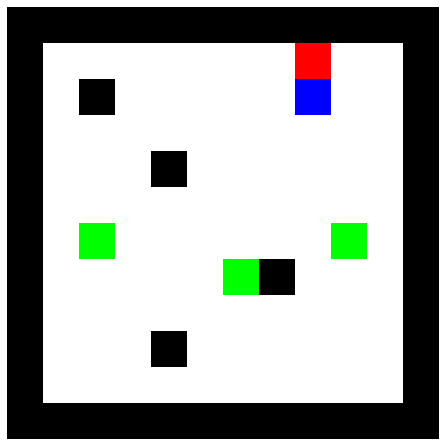

In [12]:
#Manual testing
import matplotlib.animation as animation
from time import sleep

env = Snake_game()
env.reset()

#Image for initial state
fig, ax = plt.subplots(figsize=(6,6))
plt.imshow(env.render(mode='rgb_array'))
plt.axis('off')
plt.savefig("snake_init.png",dpi=150)

#Framework to save animgif
frames = []
fps=24

n_steps = 100
for step in range(n_steps):
    obs, reward, done, info = env.step(0)
    frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
    if done:
      print("Step {}".format(step + 1))
      print("Game over!", "reward=", reward)
      break

        
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box        



In [13]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Download Video")
display(button)
def on_button_clicked(b):
  from google.colab import files
  anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
  anim.save("snake_test.mp4",dpi=150)
  files.download('snake_test.mp4')

button.on_click(on_button_clicked)


Button(description='Download Video', style=ButtonStyle())

## Monitoring
We should set up some monitoring for the training using built-in function of stable-baselines (for more advanced version see TensorBoard) and store the parameters of the best performing model

In [14]:
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import os
#Logging
log_dir = "log"
os.makedirs(log_dir, exist_ok=True)

# Instantiate the env
env = Snake_game()
# wrap it
env = Monitor(env, log_dir)


#Callback, this built-in function will periodically evaluate the model and save the best version
eval_callback = EvalCallback(env, best_model_save_path='./log/',
                             log_path='./log/', eval_freq=5000,
                             deterministic=False, render=False)

## Training
We are training the algorithm with moderate stepnumbers and manually adjust the parameters based on its perfomrance. Since we are always saving the best model we can experiment with different hyperparameters without worrying about messing up the model.

In [15]:
import time
from stable_baselines3 import PPO,DQN

#Train the agent
max_total_step_num = 1e6 #1e6

def learning_rate_schedule(progress_remaining):
    # start_rate = 0.03 #0.0001
    #Can do more complicated ones like below
    stepnum = max_total_step_num*(1-progress_remaining)
    return 0.003 * np.piecewise(stepnum, [stepnum>=0, stepnum>4e4, stepnum>2e5, stepnum>3e5], [1.0,0.5,0.25,0.125 ])
    # return start_rate * progress_remaining #linearly decreasing

PPO_model_args = {
    "learning_rate": learning_rate_schedule, #decreasing learning rate #0.0003 #can be set to constant
    "gamma": 0.90, #0.99, discount factor for futurer rewards, between 0 (only immediate reward matters) and 1 (future reward equivalent to immediate), 
    "verbose": 0, #change to 1 to get more info on training steps
    #"seed": 137, #fixing the random seed
    "ent_coef": 0.2, #0, entropy coefficient, to encourage exploration
    "clip_range": 0.2 #0.2, very roughly: probability of an action can not change by more than a factor 1+clip_range
}
starttime = time.time()
model = PPO('MultiInputPolicy', env,**PPO_model_args)
#Load previous best model parameters, we start from that
# if os.path.exists("log/best_model.zip"):
#     model.set_parameters("log/best_model.zip")
#     print("WARNING: Loaded old model")


In [16]:
model.learn(max_total_step_num,callback=eval_callback)
dt = time.time()-starttime
print("Calculation took %g hr %g min %g s"%(dt//3600, (dt//60)%60, dt%60) )

Eval num_timesteps=5000, episode_reward=-70.44 +/- 39.51
Episode length: 21.20 +/- 25.84
New best mean reward!
Eval num_timesteps=10000, episode_reward=-89.76 +/- 20.33
Episode length: 6.60 +/- 6.89
Eval num_timesteps=15000, episode_reward=-70.62 +/- 38.80
Episode length: 17.00 +/- 16.27
Eval num_timesteps=20000, episode_reward=-60.36 +/- 57.67
Episode length: 16.80 +/- 6.91
New best mean reward!
Eval num_timesteps=25000, episode_reward=-70.66 +/- 59.28
Episode length: 25.80 +/- 18.14
Eval num_timesteps=30000, episode_reward=-79.80 +/- 24.90
Episode length: 17.20 +/- 10.59
Eval num_timesteps=35000, episode_reward=-68.94 +/- 24.71
Episode length: 29.00 +/- 19.13
Eval num_timesteps=40000, episode_reward=-79.72 +/- 24.19
Episode length: 18.20 +/- 10.23
Eval num_timesteps=45000, episode_reward=-20.02 +/- 50.96
Episode length: 24.80 +/- 6.14
New best mean reward!
Eval num_timesteps=50000, episode_reward=-99.32 +/- 0.73
Episode length: 13.60 +/- 13.89
Eval num_timesteps=55000, episode_reward

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
!cp 'log/best_model.zip' "drive/My Drive/OpenAI/gym/snake/best_model.zip"

### Check performance
Basic plotting with built-in functions

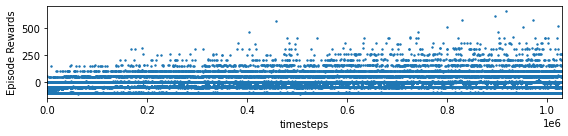

In [20]:
from stable_baselines3.common import results_plotter
# Helper from the library, a bit hard to read but immediately useable
results_plotter.plot_results(["log"], 1e7, results_plotter.X_TIMESTEPS,'')

Custom plotting

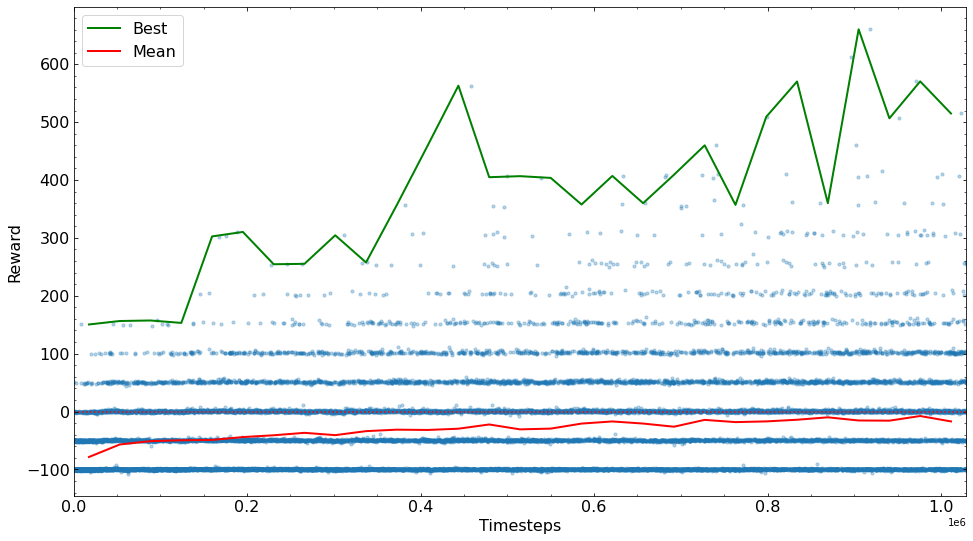

In [21]:
#A bit more advanced plotting
def adjust_font(lgnd=None, lgnd_handle_size=64, fig=None, ax_fontsize=16, labelfontsize=16,do_ticks=True ):
    if not (lgnd is None):
        for handle in lgnd.legendHandles:
            handle.set_sizes([lgnd_handle_size])
    if not (fig is None):
        ax_list = fig.axes
        for ax1 in ax_list:
            ax1.tick_params(axis='both', labelsize=ax_fontsize)
            ax1.set_xlabel(ax1.get_xlabel(),fontsize=labelfontsize)
            ax1.set_ylabel(ax1.get_ylabel(),fontsize=labelfontsize)
            if do_ticks:
                ax1.minorticks_on()
                ax1.tick_params(axis='both',which='both', direction='in',top=True,right=True)

max_possible_reward =env.REWARD_PER_FOOD * np.sum(env.init_grid==env.EMPTY)

from stable_baselines3.common.monitor import load_results
train_step_log = load_results("log")
x = np.array(train_step_log["l"].cumsum())
y = np.array(train_step_log["r"])

plot_from_step = 0
y = y[x>=plot_from_step]; x = x[x>=plot_from_step]

fig1, ax1 = plt.subplots(1,1)
fig1.set_size_inches(16, 9)

max_points_to_plot = 20000
index_to_plot = np.linspace(0,len(train_step_log)-1,np.clip(len(train_step_log),None,max_points_to_plot)).astype(int)
plt.scatter(x[index_to_plot],y[index_to_plot], alpha=0.3, s=10)

x_edges = np.linspace(x.min(),x.max(),num=30)
xbins = (x_edges[:-1]+x_edges[1:])/2.0
binnumber = np.digitize(x, x_edges) - 1
reward50=np.zeros_like(xbins); reward75=np.zeros_like(xbins); reward25=np.zeros_like(xbins); reward_mean=np.zeros_like(xbins)
reward_max = np.zeros_like(xbins)
for i in range(len(xbins)):
    ind=(binnumber==i)
    if (np.sum(ind)>0):
        reward_mean[i] = np.mean(y[ind])
        reward50[i]=np.median(y[ind])
        reward25[i]=np.percentile(y[ind],25)
        reward75[i]=np.percentile(y[ind],75)
        reward_max[i] = np.max(y[ind])

plt.plot(xbins,reward_max,c='g',lw=2, label="Best")        
plt.plot(xbins,reward_mean,c='r',lw=2, label="Mean")
#plt.plot(xbins,reward50,c='k',lw=2, label="Median")
#plt.plot(xbins,reward75,'--',c='k',lw=2, label="Interquartile range")
#plt.plot(xbins,reward25,'--',c='k',lw=2)
if plt.ylim()[1]>0.8*max_possible_reward:
    plt.axhline(y=max_possible_reward, c='r', linestyle=':')
plt.xlim([0,x.max()])
plt.xlabel('Timesteps'); plt.ylabel('Reward')
plt.legend(fontsize=16)
adjust_font(fig=fig1)
plt.savefig("snake_rewards.png",dpi=150, bbox_inches="tight")
plt.show()

## Demonstration
Once we have trained a model we can make a movie of it playing the game (which can also be used to see what behaviors it might have problems with that we can correct for in e.g., the reward scheme)

In [22]:
#Load back the best model
model.set_parameters("log/best_model.zip")
from stable_baselines3.common.evaluation import evaluate_policy
# Evaluate the trained model
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=20)
print("Best model's reward: %3.3g +/- %3.3g"%(mean_reward,std_reward))

Best model's reward: 118 +/- 134


Step 1 Action:  1 Tot. Reward: 0.2
Step 2 Action:  1 Tot. Reward: 0.4
Step 3 Action:  1 Tot. Reward: 0.6
Step 4 Action:  1 Tot. Reward: 0.8
Step 5 Action:  2 Tot. Reward: 50.7
Step 6 Action:  1 Tot. Reward: 50.9
Step 7 Action:  1 Tot. Reward: 51.1
Step 8 Action:  1 Tot. Reward: 101.3
Step 9 Action:  1 Tot. Reward: 101.5
Step 10 Action:  2 Tot. Reward: 101.4
Step 11 Action:  0 Tot. Reward: 101.3
Step 12 Action:  2 Tot. Reward: 101.2
Step 13 Action:  1 Tot. Reward: 101.4
Step 14 Action:  1 Tot. Reward: 101.6
Step 15 Action:  0 Tot. Reward: 101.5
Step 16 Action:  1 Tot. Reward: 101.7
Step 17 Action:  0 Tot. Reward: 101.6
Step 18 Action:  1 Tot. Reward: 101.8
Step 19 Action:  0 Tot. Reward: 101.7
Step 20 Action:  0 Tot. Reward: 1.6
Game over! tot. reward= 1.6000000000000654


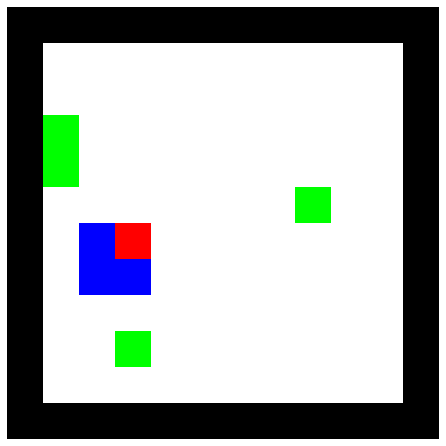

In [23]:
# Test the trained agent and save animation
obs = env.reset()
#Framework to save animgif
fig, ax = plt.subplots(figsize=(6,6))
plt.axis('off')
frames = []
fps=18

n_steps = 1000
tot_reward = 0
for step in range(n_steps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)
    tot_reward += reward
    print("Step {}".format(step + 1),"Action: ", action, 'Tot. Reward: %g'%(tot_reward))
    #print('position=', obs['position'], 'direction=', obs['direction'])
    #env.render(mode='console')
    frames.append([ax.imshow(env.render(mode='rgb_array'), animated=True)])
    if done:
        print("Game over!", "tot. reward=", tot_reward)
        break
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None) #to remove white bounding box 

In [24]:
import ipywidgets as widgets
from IPython.display import display
button = widgets.Button(description="Download Video")
display(button)
def on_button_clicked(b):
  from google.colab import files
  anim = animation.ArtistAnimation(fig, frames, interval=int(1000/fps), blit=True,repeat_delay=1000)
  anim.save("snake_test.mp4",dpi=150)
  files.download('snake_test.mp4')

button.on_click(on_button_clicked)


Button(description='Download Video', style=ButtonStyle())